In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io

import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interactive
%matplotlib inline

## Load data

In [19]:
meta = pd.read_excel('C:/Users/lan/Documents/repos/inter/mat/adp_dataset_master.xlsx', index_col=None)
meta = meta[meta.date == 210616].reset_index()
meta = meta[['mouse','date','area']]

In [17]:
nset = len(meta.index); ncell = []; nori = 7; nisi = 1; nframe_trial = 77
dir_name = 'C:\\Users\\lan\\Documents\\repos\\inter\\mat\\'

vis_ad = np.empty([0,nori]); # vis_tg = np.empty([0,1]); well_fit = np.empty([0,1])
# ori_pref = np.empty([0,nisi]); fit_param = np.empty([0,7,nisi])
dfof_ad = np.empty([0,nori]); dfof_tg = np.empty([0,nori])
dfof_ad_std = np.empty([0,nori]); dfof_tg_std = np.empty([0,nori])
trace = np.empty([0,nori,nframe_trial])

for iset in np.arange(nset):
    dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

    cell_prop = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'vis_driven' + '.mat'))
    dfof = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'dfof' + '.mat'))
    trace_align = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'trace_aligned' + '.mat'))
#     fit_tuning = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'fit_tuning_isi3' + '.mat'))
    
    ncell.append(len(cell_prop['vis_cell_ad']))    
    vis_ad = np.concatenate((vis_ad, cell_prop['sig_vis_ad']), axis=0)
#     vis_tg = np.concatenate((vis_tg, cell_prop['vis_cell_noad_tg']), axis=0)
#     well_fit = np.concatenate((well_fit, cell_prop['well_fit_cell']), axis=0)
    
#     ori_pref = np.concatenate((ori_pref, cell_prop['ori_pref']), axis=0)
#     fit_param = np.concatenate((fit_param, fit_tuning['fit_param']), axis=0)

    dfof_ad = np.concatenate((dfof_ad, dfof['dfof_ad']), axis=0)
    dfof_ad_std = np.concatenate((dfof_ad_std, dfof['dfof_ad_std']), axis=0)
    dfof_tg = np.concatenate((dfof_tg, dfof['dfof_tg']), axis=0)
    dfof_tg_std = np.concatenate((dfof_tg_std, dfof['dfof_tg_std']), axis=0)
    
    trace_flat = np.empty([ncell[iset],nori,nframe_trial]);
    for icell in np.arange(ncell[iset]):
        for iori in np.arange(nori):
#             for iisi in np.arange(nisi):
            trace_flat[icell][iori][:] = trace_align['trace_avg'][icell][iori].flatten()
    trace = np.vstack((trace,trace_flat))

# vis_tg.shape, well_fit.shape, ori_pref.shape, fit_param.shape, 
ncell, vis_ad.shape, dfof_ad.shape, dfof_tg.shape, trace.shape

([121], (121, 7), (121, 7), (121, 7), (121, 7, 77))

In [22]:
meta['ncell'] = ncell
# meta = meta.replace({'area' : { 'V1':1, 'LM':2, 'LI':3 }})
meta

,mouse,date,area,ncell
0,1338,210616,V1,121


In [24]:
mouse_cell = [item for item, count in zip(meta.mouse, meta.ncell) for i in range(count)]
area_cell = [item for item, count in zip(meta.area, meta.ncell) for i in range(count)]
meta_cell = pd.DataFrame({'mouse': mouse_cell, 'area': area_cell})
meta_cell.tail()

,mouse,area
116,1338,V1
117,1338,V1
118,1338,V1
119,1338,V1
120,1338,V1


## Adaptation magnitude

adaptation mag = response to target ori==0 with adapter / response to adapter - 1  
cell selection: vis_ad only, no dfof_ad thresholding

In [41]:
adp_mag = dfof_tg / dfof_ad - 1
adp_mag = adp_mag * vis_ad
adp_mag[adp_mag == 0] = np.nan
adp_mag.shape

(121, 7)

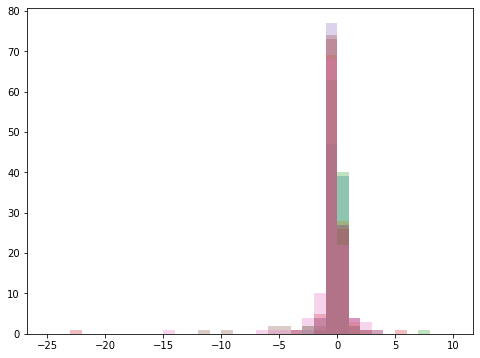

In [105]:
plt.figure(figsize=(8,6))
for iori in np.arange(nori):
#     plt.hist(adp_mag[:,iori], alpha=0.3)
    plt.hist(adp_mag[:,iori], bins=np.linspace(-25,10,36), alpha=0.3)
# plt.xlim(-25,10);

In [106]:
mag = adp_mag.flatten('F')
mag[np.abs(mag) > 50] = np.nan # force thresholding for now
stim = [np.arange(nori)] * adp_mag.shape[0]

stim_flat = np.sort([item for sublist in stim for item in sublist])
stim_flat.shape, mag.shape

<ipython-input-106-3be1e9114cc8>:2: RuntimeWarning: invalid value encountered in greater
  mag[np.abs(mag) > 50] = np.nan # force thresholding for now


((847,), (847,))

In [119]:
df = pd.DataFrame({'mag':mag, 'stim':stim_flat})
df

,mag,stim
0,NaN,0
1,-0.270371,0
2,0.404955,0
3,0.078625,0
4,0.071251,0
...,...,...
842,-0.303705,6
843,-0.946363,6
844,-4.545728,6
845,0.509572,6


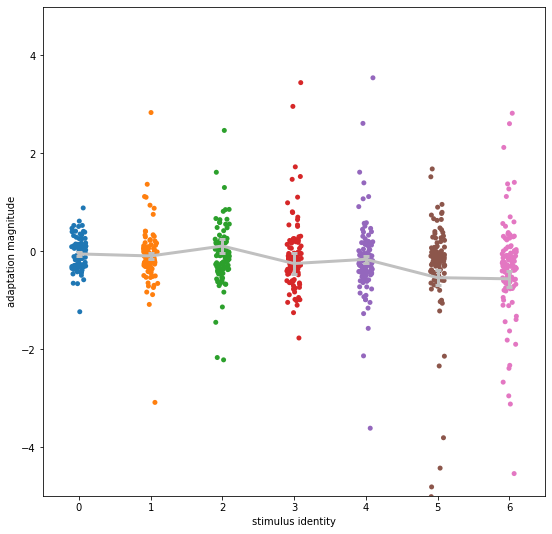

In [161]:
plt.figure(figsize=(9,9))

plt.errorbar(np.arange(nori), mag_mean, yerr=mag_sem, zorder=100, 
             color='silver', linewidth=3, capsize=3, capthick=3);
sns.stripplot(x="stim", y="mag", data=df);

plt.ylim(-5,5);
plt.ylabel('adaptation magnitude');
plt.xlabel('stimulus identity');

In [140]:
mag_mean = df[['mag','stim']].groupby(['stim'], sort=False).mean().to_numpy().flatten()
mag_median = df[['mag','stim']].groupby(['stim'], sort=False).median().to_numpy().flatten()
mag_std = df[['mag','stim']].groupby(['stim'], sort=False).std().to_numpy().flatten()
mag_sem = df[['mag','stim']].groupby(['stim'], sort=False).sem().to_numpy().flatten()
df[['mag','stim']].groupby(['stim'], sort=False).describe()

mag                                                               \
      count      mean       std        min       25%       50%       75%   
stim                                                                       
0      87.0 -0.055722  0.333009  -1.237675 -0.296637 -0.069403  0.132607   
1     103.0 -0.097542  0.573734  -3.090850 -0.298679 -0.115285  0.056971   
2     112.0  0.105213  1.533797  -2.221198 -0.364330 -0.068741  0.176492   
3     112.0 -0.252139  2.320376 -22.783439 -0.438076 -0.188977  0.145872   
4     116.0 -0.166487  0.747440  -3.618084 -0.423483 -0.192269  0.054999   
5     116.0 -0.541183  1.723481 -11.646174 -0.478584 -0.203371 -0.010074   
6     116.0 -0.565038  1.767082 -14.322533 -0.634199 -0.317729 -0.008515   

                 
            max  
stim             
0      0.883748  
1      2.833710  
2     12.859465  
3      5.441222  
4      3.543835  
5      1.681211  
6      2.819863

### add dfof_ad thresholding

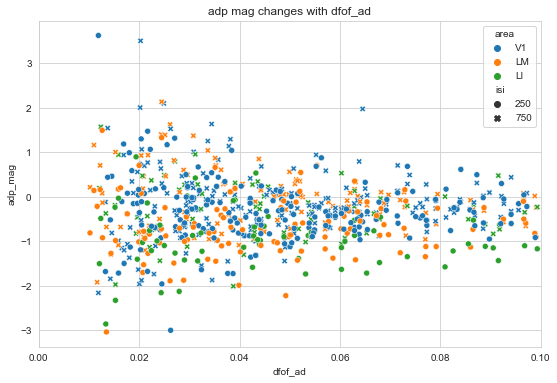

In [10]:
plt.figure(figsize=(9,6))
ax = sns.scatterplot(data=df, x="dfof_ad", y="adp_mag", hue="area", style="isi")
# plt.xlim([0,0.8]);
plt.xlim([0,0.1]);
ax.set(title = 'adp mag changes with dfof_ad');

In [641]:
df = df_adp_mag.sort_values(by=['dfof_ad'])
df1 = df[df.isi == 750]
df2 = df[df.isi == 250]

def f(win):
    plt.figure(figsize=(15,5))
    plt.plot(df1.dfof_ad, df1['adp_mag'].rolling(win, min_periods=1).mean(), alpha=0.7)
    plt.plot(df2.dfof_ad, df2['adp_mag'].rolling(win, min_periods=1).mean(), alpha=0.7)
    plt.legend(['isi = 750', 'isi = 250'])
    plt.xlim([0,0.1])
    plt.xlabel('dfof_ad')
    plt.ylabel('adaptation mag rolling mean')
    plt.title('adp mag rolling mean change with dfof_ad of cells')
    plt.show()

interactive_plot = interactive(f, win=(2, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=11, description='win', max=20, min=2), Output(layout=Layout(height='350p…

In [642]:
def f(win):
    plt.figure(figsize=(15,5))
    plt.plot(df1.dfof_ad, df1['adp_mag'].rolling(win, min_periods=1).std(), alpha=0.7)
    plt.plot(df2.dfof_ad, df2['adp_mag'].rolling(win, min_periods=1).std(), alpha=0.7)
    plt.legend(['isi = 750', 'isi = 250'])
    plt.xlim([0,0.1])
    plt.xlabel('dfof_ad')
    plt.ylabel('adaptation mag rolling std')
    plt.title('adp mag rolling std change with dfof_ad of cells')
    plt.show()

interactive_plot = interactive(f, win=(2, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=11, description='win', max=20, min=2), Output(layout=Layout(height='350p…

cell selection: vis_ad only, with dfof_ad thresholding

In [11]:
dfof_threshold = 0.03
df_adp_mag_thres = df_adp_mag[df_adp_mag.dfof_ad >= dfof_threshold]
df_adp_mag_thres.reset_index()

,index,mouse,area,isi,adp_mag,dfof_ad,vis_ad
0,0,1322,V1,750,-0.239962,0.083296,1.0
1,1,1322,V1,750,-0.267440,0.079051,1.0
2,2,1322,V1,750,0.092123,0.089755,1.0
3,3,1322,V1,750,-0.258139,0.149961,1.0
4,4,1322,V1,750,-0.049561,0.242218,1.0
...,...,...,...,...,...,...,...
753,1067,1324,LM,250,-1.037747,0.047524,1.0
754,1073,1324,LM,250,-0.744829,0.040586,1.0
755,1074,1324,LM,250,-0.274517,0.037092,1.0
756,1076,1324,LM,250,-1.451877,0.035262,1.0


In [12]:
df_adp_mag_thres[['adp_mag','area','isi']].groupby(['area','isi'], sort=False).describe()

adp_mag                                                              \
           count      mean       std       min       25%       50%       75%   
area isi                                                                       
V1   750   215.0 -0.164490  0.492664 -1.875533 -0.395995 -0.188318  0.040594   
     250   215.0 -0.362663  0.443836 -1.729659 -0.648102 -0.399921 -0.124511   
LM   750   108.0 -0.100791  0.436052 -1.089206 -0.373513 -0.076079  0.111626   
     250   108.0 -0.635745  0.510077 -2.225924 -0.915844 -0.686542 -0.359696   
LI   750    56.0 -0.321286  0.502430 -2.013799 -0.632570 -0.270519 -0.025623   
     250    56.0 -0.922097  0.467841 -1.738642 -1.185452 -0.971112 -0.737692   

                    
               max  
area isi            
V1   750  1.972312  
     250  1.149798  
LM   750  1.369365  
     250  0.703521  
LI   750  0.951508  
     250  0.530749

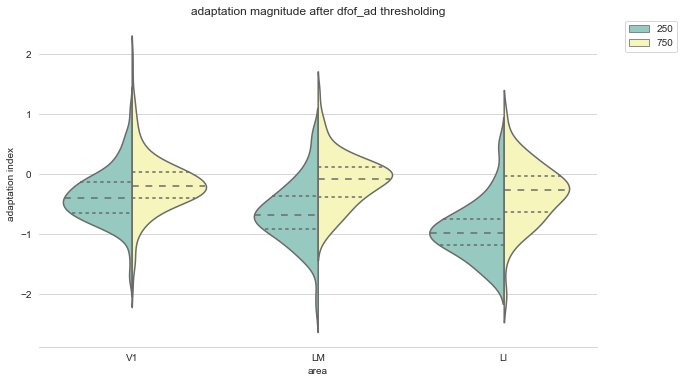

In [13]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
ax = sns.violinplot(data=df_adp_mag_thres, x="area", y="adp_mag", hue="isi",
               split=True, inner="quart", palette="Set3")
sns.despine(left=True)
ax.set(ylabel = 'adaptation index', title = 'adaptation magnitude after dfof_ad thresholding');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

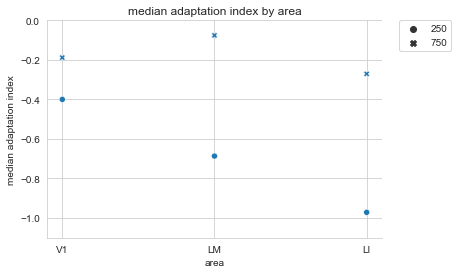

In [14]:
t = df_adp_mag_thres.copy()
tt = t[['adp_mag','area','isi']].groupby(['area','isi'], sort=False).median().reset_index()

ax = sns.scatterplot(data=tt, x="area", y="adp_mag", style="isi"); sns.despine()
ax.set(ylabel = 'median adaptation index', title = 'median adaptation index by area')
plt.ylim([-1.1,0])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## Trace

## Misc
### Adaptation increases variability (?)
for ori=0 target after adaptation, fano factor is higher than adapter  
cell selection: vis_ad only, with thresholding of dfof_ad & dfof_tg0

In [50]:
adp_fano_tg = dfof_tg_std[:,0,[1,2]] / dfof_tg[:,0,[1,2]]
adp_fano_ad = dfof_ad_std / dfof_ad
adp_fano = (adp_fano_tg - adp_fano_ad) / (adp_fano_tg + adp_fano_ad) # range [-1,1], meaning fano factor de/increase after adp
# adp_fano = (adp_fano_tg - adp_fano_ad) / (adp_fano_ad)

df_adp_fano = meta_cell_isi.copy()
df_adp_fano['adp_fano'] = adp_fano.flatten('F')
df_adp_fano['dfof_ad'] = np.concatenate((dfof_ad, dfof_ad), axis=0)
df_adp_fano['dfof_tg'] = np.concatenate((dfof_tg[:,0,1], dfof_tg[:,0,2]), axis=0)

df_adp_fano['vis_ad'] = np.concatenate((vis_ad, vis_ad), axis=0)
df_adp_fano = df_adp_fano[ df_adp_fano['vis_ad'] == 1 ]

df_adp_fano = df_adp_fano[(df_adp_fano.dfof_ad >= dfof_threshold) & (df_adp_fano.dfof_tg >= dfof_threshold)]
df_adp_fano.reset_index()

,index,mouse,area,isi,adp_fano,dfof_ad,dfof_tg,vis_ad
0,0,1322,V1,750,0.198528,0.083296,0.063308,1.0
1,1,1322,V1,750,0.249547,0.079051,0.057910,1.0
2,2,1322,V1,750,0.224684,0.089755,0.098024,1.0
3,3,1322,V1,750,0.069735,0.149961,0.111251,1.0
4,4,1322,V1,750,0.079733,0.242218,0.230214,1.0
...,...,...,...,...,...,...,...,...
503,1040,1324,LM,250,0.136103,0.194892,0.174791,1.0
504,1045,1324,LM,250,0.091489,0.191068,0.180989,1.0
505,1053,1324,LM,250,0.329836,0.116363,0.086052,1.0
506,1061,1324,LM,250,-0.081032,0.052181,0.080558,1.0


In [51]:
df_adp_fano[['adp_fano','area','isi']].groupby(['area','isi'], sort=False).describe()

adp_fano                                                              \
            count      mean       std       min       25%       50%       75%   
area isi                                                                        
V1   750    175.0  0.068245  0.149348 -0.318383 -0.037016  0.081278  0.167854   
     250    146.0  0.128114  0.173747 -0.346164  0.012119  0.120236  0.229368   
LM   750     92.0  0.030203  0.178669 -0.410187 -0.083335  0.036848  0.138752   
     250     44.0  0.153444  0.216884 -0.223757 -0.010786  0.147786  0.317559   
LI   750     40.0  0.006787  0.151909 -0.438364 -0.067491 -0.001452  0.103903   
     250     11.0  0.242941  0.224277 -0.173832  0.097539  0.259875  0.366242   

                    
               max  
area isi            
V1   750  0.397835  
     250  0.646350  
LM   750  0.478017  
     250  0.585548  
LI   750  0.361342  
     250  0.686797

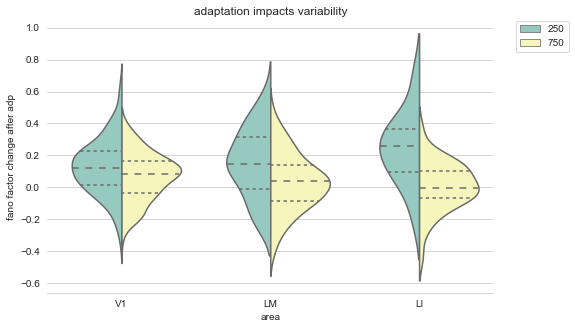

In [53]:
sns.set_style("whitegrid")
plt.figure(figsize=([8,5]))
ax = sns.violinplot(data=df_adp_fano, x="area", y="adp_fano", hue="isi",
               split=True, inner="quart", palette="Set3")
sns.despine(left=True)
ax.set(ylabel = 'fano factor change after adp', title = 'adaptation impacts variability')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [54]:
def violinplot(df, ix, iy, ihue, iylabel, ititle, fig_size=[8,5]):
    # ivar = string
    # violinplot(df_adp_fano, "area", "adp_fano", "isi", 'fano factor change after adp', 'adaptation impacts variability')
    
    sns.set_style("whitegrid")
    plt.figure(figsize=(fig_size))
    ax = sns.violinplot(data=df, x=ix, y=iy, hue=ihue, split=True, inner="quart", palette="Set3")
    sns.despine(left=True)
    ax.set(ylabel = iylabel, title = ititle)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);